# Face Recognation 
Project based on: [Build a Deep Facial Recognition App](https://www.youtube.com/watch?v=bK_k7eebGgc&list=PLgNJO2hghbmhHuhURAGbe6KWpiYZt0AMH)

# 1. Set up and get data

# 1.1 Install dependencies

!pip install tensorflow

In [24]:
!pip install labelme tensorflow opencv-python matplotlib albumentations

## 1.2 Collect images using openCV

In [55]:
import os
import time
import uuid # for unique id
import cv2

In [15]:
IMAGES_PATH = os.path.join('data', 'images')
NUM_IMAGES_TO_COLLECT = 20

In [16]:
# Conection to video camera and get images
cap = cv2.VideoCapture(0) # if you are on winodws try 1 instead of 0
for imgnum in range(NUM_IMAGES_TO_COLLECT):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'): # turn off the camera
        break
cap.release()
cv2.destroyAllWindows()

## 1.3 Annotate images with labelMe

In [19]:
#/Users/asialalala/.local/pipx/venvs/labelme/bin/labelme
!labelme

2024-05-04 18:37:50,507 [INFO   ] __init__:get_config:67- Loading config file from: C:\Users\biuro\.labelmerc


# 2. Review Dataset and Build Image Loading Function

## 2.1 Import packages

In [34]:
import sys
sys.executable

'C:\\Users\\biuro\\lab1\\Scripts\\python.exe'

In [1]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

## 2.2 Limit GPU Memory Growth

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
# WARNING!!!! It should be trye, but it is false

In [24]:
# check if tensorflow is available
tf.config.list_physical_devices('GPU')
#tf.config.list_physical_devices('GPU')
tf.test.is_gpu_available()

False

In [33]:
images = tf.data.Dataset.list_files('data/images/*.jpg')

In [34]:
# variable 'images' contains path to images files
images.as_numpy_iterator().next()

b'data\\images\\0b36b116-0853-11ef-9d21-64d2c4ecd148.jpg'

In [35]:
# read images and load them as jpeg to img
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [36]:
images = images.map(load_image)

In [37]:
images.as_numpy_iterator().next()

array([[[ 15,  12,   0],
        [ 13,  10,   0],
        [ 13,  11,   0],
        ...,
        [129, 117, 119],
        [131, 119, 121],
        [131, 119, 121]],

       [[ 15,   9,   0],
        [ 14,  11,   0],
        [ 20,  16,   4],
        ...,
        [130, 118, 120],
        [131, 119, 121],
        [130, 118, 118]],

       [[ 18,  10,   0],
        [ 18,  12,   0],
        [ 27,  21,   9],
        ...,
        [128, 118, 117],
        [131, 121, 120],
        [134, 124, 122]],

       ...,

       [[  6,   0,  10],
        [  5,   2,  11],
        [  7,   1,  11],
        ...,
        [254, 255, 253],
        [255, 255, 255],
        [255, 255, 255]],

       [[  4,   1,   8],
        [  2,   1,   7],
        [  3,   0,   7],
        ...,
        [254, 255, 253],
        [255, 255, 255],
        [255, 254, 255]],

       [[  2,   1,   7],
        [  1,   0,   6],
        [  1,   0,   6],
        ...,
        [253, 255, 250],
        [254, 254, 255],
        [254, 253, 255]]

## 2.4 View Raw Images with Matplotlib

In [38]:
image_genarator = images.batch(4).as_numpy_iterator()

In [42]:
plot_images = image_genarator.next() #geting new batch of data, can be ran multiple time

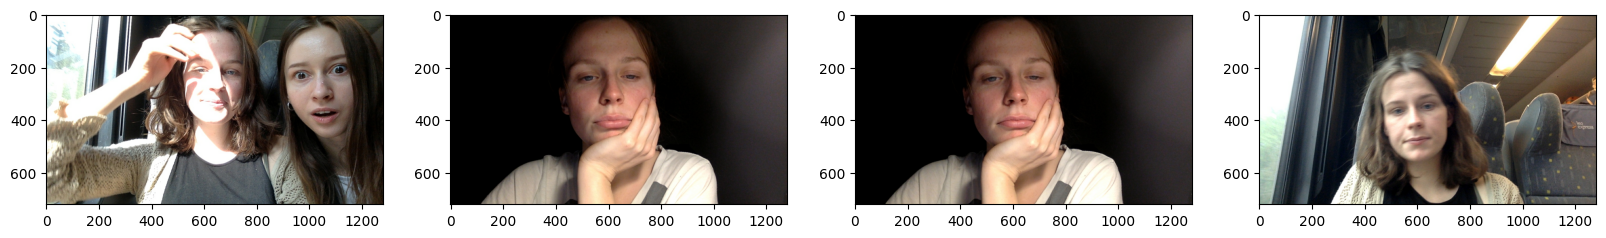

In [43]:
#show 4 images, if you want another butch just ran cell below and then this one
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()                      

# 3. Partition Unaugmented Data

## 3.1 Manually Split Sata into Train Test and Val

In [ ]:
#if we add new data we need to also divide it and add to folders

In [51]:
176*0.7 #123 to train

123.19999999999999

In [52]:
176*.15 # 26 and 27 to test and val

26.4

## 3.2 Move the Matching Labels

In [75]:
#moving matching labels to the photos in new folders
for folder in ['train', 'test', 'val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        filename = file.split('.')[0] + '.json'
        existing_filepath = os.path.join('data', 'labels', filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data', folder, 'labels', filename)
            os.replace(existing_filepath, new_filepath) 
#i'm not sure if it do it for all files but it did for some

# 4. Apply Image Augmentation on Images and Labels using Albumentations

## 4.1 Setup Albumentations Transform Pipline

In [77]:
import albumentations as alb

In [103]:
#adjust photos and normalization (bbox)
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450),
                         alb.HorizontalFlip(p=0.5), alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2),alb.RGBShift(p=0.2),alb.VerticalFlip(p=0.5)],
                        bbox_params=alb.BboxParams(format='albumentations', label_fields=['class_labels']))

## 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [118]:
img = cv2.imread(os.path.join('data','train','images','547b89de-07fc-11ef-b710-64d2c4ecd148.jpg')) #if dosen't return error -> works

In [119]:
with open(os.path.join('data','train','labels','547b89de-07fc-11ef-b710-64d2c4ecd148.json'), 'r') as f:
    label = json.load(f)

In [113]:
#label #to check if it works, also can check type or use label['shapes'] or label['shapes'][0]['points'] for coordinate

## 4.3 Extract Cooridnates and Rescale to Match Image Resolution

In [124]:
coords = [0,0,0,0]
coords[0]=label['shapes'][0]['points'][0][0]
coords[1]=label['shapes'][0]['points'][0][1]
coords[2]=label['shapes'][0]['points'][1][0]
coords[3]=label['shapes'][0]['points'][1][1]

In [115]:
coords #vector with coordinates

[474.0909090909092, 243.33333333333334, 715.0, 581.2121212121212]

In [125]:
coords = list(np.divide(coords, [640,480,800,600])) #normalization, ir should be [640,480,640,480], but its to little and normalization is not in range 0-1

In [126]:
coords

[0.5253314393939396,
 0.09027777777777786,
 0.9486742424242425,
 0.9510101010101011]

## 4.4 Apply Augmentation and View Results

In [127]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face']) #sth wrong here, it doesnt assign coords or labels

In [135]:
augmented['bboxes']

[]

In [132]:
cv2.rectangle(augmented['image'],
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)),
              (255,0,0),2)

plt.imshow(augmented['image'])

IndexError: list index out of range